# Fasting (Python Package)
## _Make use of your fasting logs._

This tutorial provides a brief overview of how to use the **fasting** library. We'll use a sample data export from [**Zero**](https://www.zerofasting.com/) in the tutorial.

This package is part of the [**Digital Biomarker Discovery Pipeline (DBDP)**](https://dbdp.org/). You can read more about the DBDP [here](https://medium.com/digital-biomarker-discovery/digital-biomarker-discovery-pipeline-fbfe75cdd9a4). If you track your fasts, there's a chance you also track biomarkers with wearables and other hardware in the modern health stack. The goal of this package is to enable you to utlize _**your**_ data for your own purpose, like cross analyzing fasting performance with other biomarkers. 


### Fasting
Fasting is a technique used to improve metabolic health, reduce inflammation, rebalance gut health, lose weight, increase longevity, improve mental clarity and focus. 

There's various forms of fasting, with **Intermittent Fasting (IF)** likely being the most common. You can read about **IF** and other types of fasting on the [Zero blog](https://www.zerofasting.com/which-type-of-fasting-is-right-for-you/).

## Getting Started

Let's start by importing the packages we'll need for this tutorial. 

In [3]:
from fasting import quantify
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

## Data
**Zero** provides a data export feature in their app.
This [dataset](https://github.com/jbpauly/fasting/blob/main/docs/tutorials/zero_export.csv) is a sample users can expect to see from their own export.

### Exporting Data from Zero
The data export feature in Zero can be found in the **My Data** section in the **me** page settings. To export your own data:
- Me (lower right) -> Settings (upper right) -> My Data -> Export Data

### Loading the Data
First we'll load the raw data export into a Pandas DataFrame to better understand _why_ we need to use the **fasting** library.

In [4]:
export = "https://raw.githubusercontent.com/jbpauly/fasting/main/docs/tutorials/zero_export.csv"

In [5]:
zero_export = pd.read_csv(export)

zero_export[-5:]

,Date,Start,End,Hours,Night Eating
24,1/18/21,19:14,11:44,16,1
25,1/17/21,19:15,12:00,16,1
26,1/16/21,19:45,10:14,14,2
27,1/15/21,21:00,10:00,13,3
28,1/14/21,19:00,11:22,16,1


Here we can see the raw data export provides sufficient data around each fast a user participated in through the **Zero** app. 

- **Date**: Start date of the fast
- **Start**: Start time of the fast
- **End**: End time of the fast
- **Hours**: Duration of the fast rounded to the nearest hour
- **Night Eating**: Duration of time between sunset and fast start in hours

Alone, **hours** and **night eating** are usable metrics, but there's much more to gather out of our dataset. To do so, we'll simplify the logs to a **start datetime** and **end datetime** for each fast by combining **date**, **start**, **end**, **hours**.

## Discrete Logs: Start and End Datetime
To create the discrete logs, lets read in the data using the **zero_fasts** function in the **quantify** module.

In [6]:
fasts_discrete = quantify.zero_fasts(export)

fasts_discrete[:5]

,start_dt,end_dt
0,2021-01-14 19:00:00,2021-01-15 11:22:00
1,2021-01-15 21:00:00,2021-01-16 10:00:00
2,2021-01-16 19:45:00,2021-01-17 10:14:00
3,2021-01-17 19:15:00,2021-01-18 12:00:00
4,2021-01-18 19:14:00,2021-01-19 11:44:00


We now have a start and end datetime (start_dt, end_dt) to work with for each fast. Additionally, the fasts are reindexed from oldest to newest, and any incomplete or ongoing fasts have been dropped.

### Why start and end datetime?
Because fasting is primarily a time based protocol, it's important to get our data into a datetime format. From here we can take it one step further from discrete logs with start and end datetimes to a continuous time series log. Time series data can be tricky to handle. To overcome many challenges working with time based data, it's useful to work with it _as a time series_. 

## Continuous Log: Time Series of Fasting Status (not fasting/fasting)
Lets now convert the the discrete logs to a single continuous log using the **continuous_fasts** function in the **quantify** module. This function reads in the discrete fasts as a Pandas DataFrame and returns a binary Pandas Series:
- 0: Not fasting
- 1: Fasting

The series duration spans from the **start_dt** of the first fast in the discrete fasts log to the **end_dt** of the last fast in the discrete fasts log and has a sample rate of one minute.

In [42]:
fasts_continuous = quantify.continuous_fasts(fasts_discrete)

fasts_continuous[:5]

2021-01-14 19:00:00    1
2021-01-14 19:01:00    1
2021-01-14 19:02:00    1
2021-01-14 19:03:00    1
2021-01-14 19:04:00    1
Freq: T, dtype: int64

It's now less useful to tabularize the data. Instead, we can visualize it.

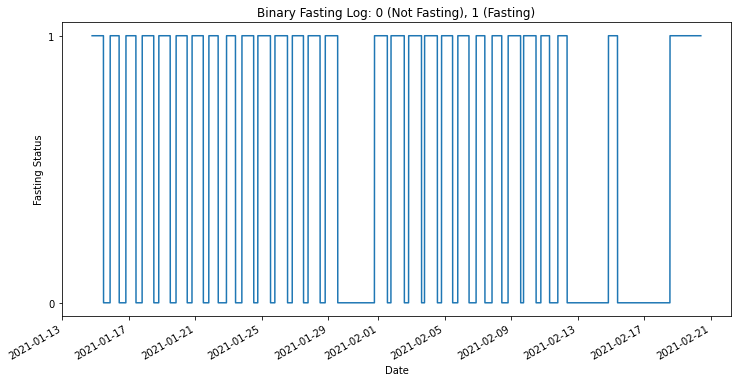

In [93]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(fasts_continuous)
fig.autofmt_xdate()
plt.title('Binary Fasting Log: 0 (Not Fasting), 1 (Fasting)')
plt.xlabel('Date')
plt.ylabel('Fasting Status')
ax.set_yticks([0,1])
plt.show()

### Why a continuous time series?
Pandas and other Python libraries support a vast array of time series functionality. To utilize these libraries, we often need our data as a series to perform aggregations, windowing functions, etc.

For data storage, it may be best to write discrete logs to a database instead of a continuous log. Two data points (start and end datetime) is much less than the thousands of points in a single fast continuous log. 

## Fasting Metrics 
With the continuous log, we can now calculate various metrics of interest around our fasts.

### Continuous Metrics
There may be some instances where it's useful to stay in the continuous space, like calculating the cumulative sum (consecutive) minutes of each fast.

In [55]:
consecutive_minutes = quantify.consecutive_minutes(fasts_continuous)

consecutive_minutes[:5]

2021-01-14 19:00:00    1
2021-01-14 19:01:00    2
2021-01-14 19:02:00    3
2021-01-14 19:03:00    4
2021-01-14 19:04:00    5
Freq: T, dtype: int64

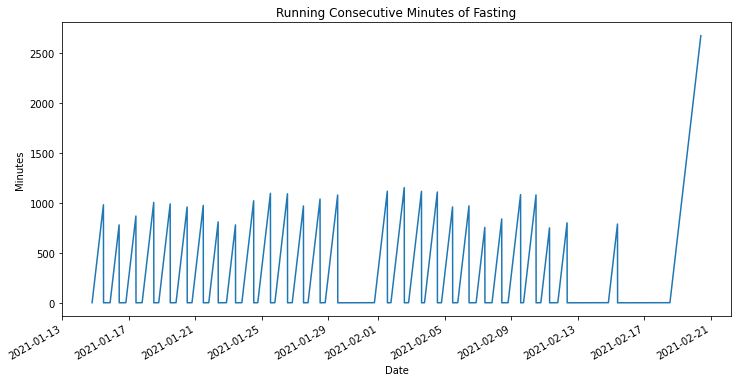

In [98]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(consecutive_minutes)
fig.autofmt_xdate()
plt.title('Running Consecutive Minutes of Fasting')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.show()

With the consecutive minutes, you could label each time step with the associated fasting zone*:
- **Anabolic** (0-4 hours)
- **Catabolic** (4-16 hours)
- **Fat Burning** (16-24 hours)
- **Ketosis** (24-72 hours)
- **Deep Ketosis** (72+ hours)

*Note: this can be provided as a function in fuction versions of the package.

![](https://www.zerofasting.com/wp-content/uploads/2019/08/1_NcXg95jV94rWENSAcdPEmg.jpg)
Unique physiologic effects occur within each fasting zone. You can learn more about the physiology of fasting from Zero [here](https://www.zerofasting.com/the-physiology-of-fasting/).

### Discrete Metrics
Often times, biometrics are rolled up to discrete metrics at a specified frequency (i.e. daily). Since fasts can span across multiple days and multiple fasts can occur in a single day, we have to be careful how we roll up our discrete metrics. The image below helps explain calculations like **cumulative hours** and **maximum consecutive hours** fasted.

![Link](https://raw.githubusercontent.com/jbpauly/glucose-sleep-analysis/main/src/content/data/fast_breakdown.jpg)

This diagram also reiterates the importance of working with time data as a time series. Even though we are calculating discrete metrics, it's easier to go from a higher data space (continuous log) down to a lower data space (daily metrics).

#### Cumulative Hours
Simply the cumulative hours fasting each day. Since the continuous log is a binary series of 0's and 1's, we can sum the series at a daily frequency.

In [54]:
cumulative_hours = quantify.daily_cumulative_hours(fasts_continuous)

cumulative_hours[:5]

2021-01-14     5.000000
2021-01-15    14.383333
2021-01-16    14.266667
2021-01-17    15.000000
2021-01-18    16.783333
Freq: D, dtype: float64

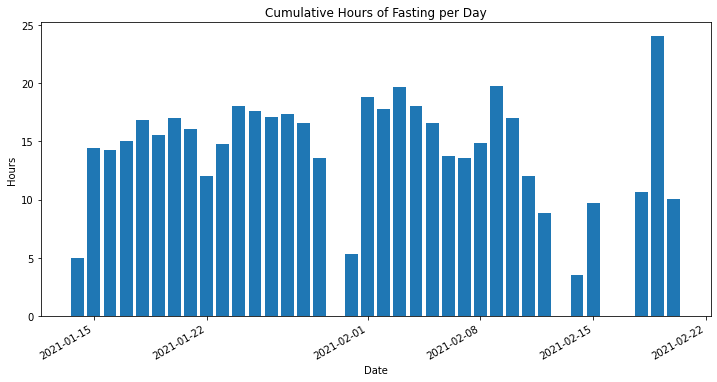

In [99]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(cumulative_hours.index, cumulative_hours.values)
fig.autofmt_xdate()
plt.title('Cumulative Hours of Fasting per Day')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.show()

#### Maximum Consecutive Hours
You may participate in multiple fasts each day. Maybe you complete one fast at 12PM with lunch and start your next fast at 7PM after dinner. The **maximum consecutive hours** is the maximum consecutive hours fasted within each day. It can included hours rolled over from previous day(s).

In [56]:
max_consecutive_hours = quantify.daily_max_consecutive_hours(fasts_continuous)

max_consecutive_hours[:5]

2021-01-14     5.000000
2021-01-15    16.383333
2021-01-16    13.016667
2021-01-17    14.500000
2021-01-18    16.766667
Freq: D, dtype: float64

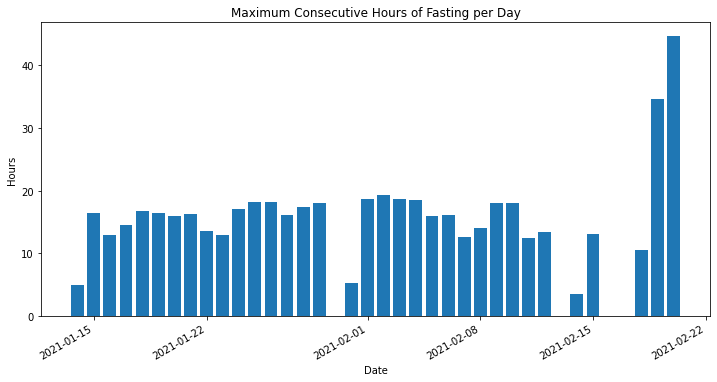

In [101]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(max_consecutive_hours.index, max_consecutive_hours.values)
fig.autofmt_xdate()
plt.title('Maximum Consecutive Hours of Fasting per Day')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.show()

## Summary
That's it! We've loaded a data export from Zero and explored some of the metrics we can calculate with the **fasting** package. How can you use your data along with other tracked biometrics? Check out this [app](https://share.streamlit.io/jbpauly/glucose-sleep-analysis/main/src/app.py) and explore of the relationship be lifestyle and metabolic health. 